# Informer

시작 전에 파이썬 버전과 GPU 정보, CUDA 가용 여부를 확인한다.

In [1]:
!python --version

Python 3.7.15


In [2]:
!nvidia-smi

Fri Oct 28 15:04:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
torch.cuda.is_available()

True

### 데이터셋

ETTh1 데이터셋을 다운로드한다. ETT(Electricity Transformer Temperature) 데이터셋은 2016년 7월부터 2018년 7월까지 측정된 중국의 전기 변압기 온도에 대한 시계열 데이터다. 각 컬럼의 의미는 아래 표와 같다.

| Field | date | HUFL | HULL | MUFL | MULL | LUFL | LULL | OT |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| Description | The recorded **date** |**H**igh **U**se**F**ul **L**oad | **H**igh **U**se**L**ess **L**oad | **M**iddle **U**se**F**ul **L**oad | **M**iddle **U**se**L**ess **L**oad | **L**ow **U**se**F**ul **L**oad | **L**ow **U**se**L**ess **L**oad | **O**il **T**emperature (target) |

타겟 컬럼은 OT(Oil Temperature)이다. 오일 온도는 변압기의 상태에 따라 변하며, 특히 전기 사용량이 많아지는 시기에 온도가 상승한다. 오일 온도가 너무 높으면 변압기가 손상되어 대규모 정전 사태를 야기할 수 있기 때문에 변압기의 오일 온도가 안전한지 예측하는 것은 중요한 문제다.

In [4]:
%cd /content
!mkdir -p dataset
!curl https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv > dataset/ETTh1.csv

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2528k  100 2528k    0     0  6386k      0 --:--:-- --:--:-- --:--:-- 6370k


In [5]:
import pandas as pd
data = pd.read_csv('/content/dataset/ETTh1.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    17420 non-null  object 
 1   HUFL    17420 non-null  float64
 2   HULL    17420 non-null  float64
 3   MUFL    17420 non-null  float64
 4   MULL    17420 non-null  float64
 5   LUFL    17420 non-null  float64
 6   LULL    17420 non-null  float64
 7   OT      17420 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


날짜에 따른 OT(Oil temperature) 변화를 시각화해 확인해본다. 여기에서는 336건의 과거 시점(그래프에서 파란색 선)을 바탕으로 96건의 미래 시점(그래프에서 주황색 선)을 예측할 것이다. 

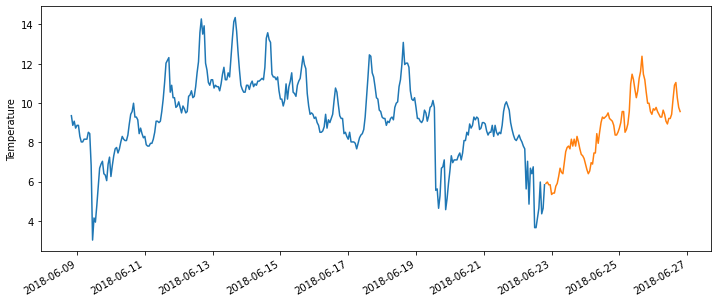

In [7]:
import matplotlib.pyplot as plt

seq_len = 336
pred_len = 96

plt.figure(figsize=(12,5))
plt.ylabel('Temperature')
data_to_show = data.set_index(pd.to_datetime(data['date']))
plt.plot(data_to_show['OT'][-(seq_len + pred_len):-pred_len])
plt.plot(data_to_show['OT'][-pred_len:])
plt.gcf().autofmt_xdate()
plt.show()

## 구현체 다운로드 및 패키지 설치

([H. Zhou, 2021](https://arxiv.org/abs/2012.07436))에서 제시된 것과 같은 Informer 모델의 pytorch 구현체를 다운로드하고 필요한 파이썬 패키지를 설치한다.

In [8]:
%cd /content
!git clone https://github.com/zhouhaoyi/Informer2020.git
%cd /content/Informer2020
!ls

/content
Cloning into 'Informer2020'...
remote: Enumerating objects: 573, done.
remote: Total 573 (delta 0), reused 0 (delta 0), pack-reused 573
Receiving objects: 100% (573/573), 6.48 MiB | 20.61 MiB/s, done.
Resolving deltas: 100% (328/328), done.
/content/Informer2020
data		 exp	  main_informer.py  README.md	      utils
Dockerfile	 img	  Makefile	    requirements.txt
environment.yml  LICENSE  models	    scripts


In [9]:
#!pip install -r requirements.txt

## 학습 및 테스트

각종 파라미터를 조정한다. 여기서는 `seq_len`(336)건의 과거 시계열 데이터를 학습해 `pred_len`(96)건의 미래 시계열을 예측한다.

In [10]:
import os
import torch
import numpy as np
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer

args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh1' # data
args.root_path = '/content/dataset/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = seq_len # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = pred_len # prediction sequence length

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0
args.use_multi_gpu = False
args.devices = '0,1,2,3'

if args.use_gpu and args.use_multi_gpu:
  args.devices = args.devices.replace(' ','')
  device_ids = args.devices.split(',')
  args.device_ids = [int(id_) for id_ in device_ids]
  args.gpu = args.device_ids[0]

args.detail_freq = args.freq
args.freq = args.freq[-1:]

setting = ''
exp = Exp_Informer(args)

setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_0'.format(
  args.model, args.data, args.features, args.seq_len, args.label_len, args.pred_len, args.d_model,
  args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

Use GPU: cuda:0


조정된 파라미터에 따라 학습한다.

In [11]:
exp.train(setting)

train 8209
val 2785
test 2785
	iters: 100, epoch: 1 | loss: 0.4553979
	speed: 0.2779s/iter; left time: 399.3247s
	iters: 200, epoch: 1 | loss: 0.5064920
	speed: 0.1928s/iter; left time: 257.7578s
Epoch: 1 cost time: 58.16307282447815
Epoch: 1, Steps: 256 | Train Loss: 0.5220819 Vali Loss: 1.2838256 Test Loss: 1.0641946
Validation loss decreased (inf --> 1.283826).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.3938587
	speed: 0.4517s/iter; left time: 533.4090s
	iters: 200, epoch: 2 | loss: 0.3854823
	speed: 0.2021s/iter; left time: 218.5127s
Epoch: 2 cost time: 51.811084508895874
Epoch: 2, Steps: 256 | Train Loss: 0.3739711 Vali Loss: 1.1741935 Test Loss: 1.0399895
Validation loss decreased (1.283826 --> 1.174194).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.2536044
	speed: 0.4466s/iter; left time: 413.1181s
	iters: 200, epoch: 3 | loss: 0.2429371
	speed: 0.2010s/iter; left time: 165.7905s
Epoch: 3 cost time: 51.

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

학습된 모델로 예측을 테스트한다. 이때 MSE, MAE 지표를 확인할 수 있다.

In [12]:
exp.test(setting)
torch.cuda.empty_cache()

test 2785
test shape: (87, 32, 96, 7) (87, 32, 96, 7)
test shape: (2784, 96, 7) (2784, 96, 7)
mse:1.1859378814697266, mae:0.8793039321899414


예측 데이터를 실제 데이터와 함께 시각화해보면 아래와 같다.

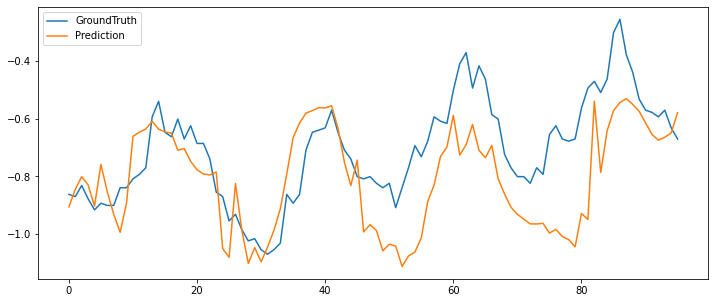

In [13]:
pred = np.load('results/{}/pred.npy'.format(setting))
trues = np.load('results/{}/true.npy'.format(setting))

plt.figure(figsize=(12, 5))
plt.plot(trues[0,:,-1], label="GroundTruth")
plt.plot(pred[0,:,-1], label="Prediction")
plt.legend()
plt.show()